In [1]:
import sys
import os
sys.path.append(os.path.join("..", ".."))
from data_pipeline.dataset import CARLADataset
from data_pipeline.dataset_xy import CARLADatasetXY
from data_pipeline.data_preprocessing import preprocessing
from data_pipeline.utils import create_metadata_df, train_test_split
from data_pipeline.data_preprocessing import preprocessing 

from torch.utils.data import DataLoader
from torchvision import transforms as T
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## path_ege_data = os.path.join("..", "data", "Dataset Ege")

path_data = "/Volumes/Ege_External/Town_1_2_Dataset/Training"
path_data = os.path.join("..", "..", "data", "data")

config = {"used_inputs": ["rgb", "lidar_bev", "measurements"], 
        "used_measurements": ["command"],    
        "seq_len": 1
        }

train_test_config = {
    "train": ['Town00', 'Town01', 'Town02', 'Town03', 'Town04', 'Town05', 'Town07', 'Town08', 'Town09', 'Town10'],
    "test": ['Town06']
}

mean = torch.tensor([79.6657, 81.5673, 105.6161])
std = torch.tensor([66.8309, 60.1001, 66.2220])



df_meta_data = create_metadata_df(path_data, config["used_inputs"])
df_meta_data_train, df_meta_data_test_1, df_meta_data_test_2 = train_test_split(df_meta_data, towns_intersect=train_test_config, df_meta_data_noisy=None)

dataset = CARLADataset(root_dir=path_data, df_meta_data=df_meta_data_train, config=config )

print(dataset.__len__())
print((dataset.__getitem__(1)['lidar_bev'].shape))

205560
(1, 3, 161, 161)


In [3]:
dl = DataLoader(dataset=dataset, batch_size=16, num_workers=0)
# dl_mp = DataLoader(dataset=dataset_mp, batch_size=16, num_workers=3, sampler=weighted_sampler)

Text(0.5, 1.0, 'distribution of pixels')

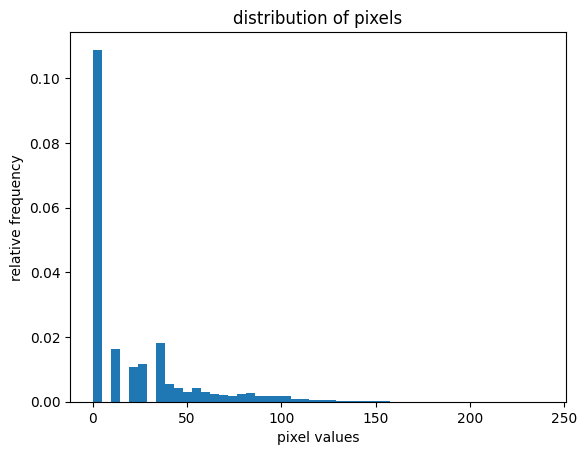

In [4]:
img_np = np.array(dataset.__getitem__(1)['rgb'])
 
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

Cell Below calculates the mean and std for the rbg images in the dataset. Make sure to run it only once for calculation, save the total_mean and total_std variables, and input them in the normalization step.

In [5]:
transform = T.Compose([
    T.Resize([80, 480]),
])

psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(dl):
    inputs = torch.squeeze(inputs["rgb"])
    # inputs = inputs.numpy()
    # inputs = inputs.astype("uint8")
    inputs = transform(inputs)
    inputs = inputs/255
    psum    += inputs.sum(axis = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])


# pixel count
count = dataset.__len__() * 80 * 480

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

100%|██████████| 12848/12848 [43:17<00:00,  4.95it/s]

mean: tensor([0.3848, 0.3718, 0.3261])
std:  tensor([0.2627, 0.2557, 0.2517])


In [11]:
for batch in dl:
    break

In [14]:
torch.squeeze(batch["lidar_bev"]).shape

torch.Size([16, 3, 641, 641])

In [15]:
# LiDAR where transformed to 641x641 --> Resize is necessary

psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(dl):
    inputs = torch.squeeze(inputs["lidar_bev"])
    inputs = T.Resize([224, 224])(inputs)
    inputs = inputs / 255
    psum    += inputs.sum(axis = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])


# pixel count
count = dataset.__len__() * 224 * 224

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

100%|██████████| 12848/12848 [1:04:40<00:00,  3.31it/s]

mean: tensor([0.0015, 0.0015, 0.0015])
std:  tensor([0.0236, 0.0236, 0.0236])


In [4]:
# LiDAR where transformed to 161*161 --> No resize necessary

psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(dl):
    inputs = torch.squeeze(inputs["lidar_bev"])
    inputs = inputs / 255
    psum    += inputs.sum(axis = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])


# pixel count
count = dataset.__len__() * 161 * 161

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

100%|██████████| 12848/12848 [37:18<00:00,  5.74it/s]

mean: tensor([0.0605, 0.0605, 0.0605])
std:  tensor([0.1498, 0.1498, 0.1498])
